# Load librariers and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_pickle('df_userID.pickle')
data.columns

Index(['Race', 'Date', 'RaceYear', 'RaceMonth', 'Category', 'Distance', 'Name',
       'Sex', 'Year', 'LivingPlace', 'Rank', 'Time', 'Pace', 'Place',
       'MinTemp', 'MaxTemp', 'Weather', 'RaceID', 'UserID'],
      dtype='object')

# Geographical analysis

In this section we want to find if there are statistically remarkable differences in terms of performance between runners from different Cantons. At first we have then to link each provenience city (saved as 'LivingPlace' in the dataset) to its own Canton. We will consider only the major Swiss cities in this analysis. The reader can refer to the following [web page](http://official-swiss-national-languages.all-about-switzerland.info/names-swiss-villages-towns-languages.html). This approximate procedure allows us to map roughly the 40% of the whole dataset, as we will verify. The geographical information is saved in an excel file named 'swisscities.xlsx'.

In [3]:
cities = pd.read_excel('swisscities.xlsx')
cities = cities[['Village / Town','Canton']]
cities['City']=cities['Village / Town']
del cities['Village / Town']

In [4]:
cities.head()

,Canton,City
0,TG,Aadorf
1,AG,Aarau
2,BE,Aarberg
3,AG,Aarburg
4,BE,Aarwangen


We extract all the living places in the dataset:

In [5]:
provenience = data.LivingPlace.unique()

Then we map each city to its own Canton, whenever it is possible; otherwise we set the corresponding Canton to 'nan' (null value).

In [27]:
general_mapping = {}
for city in provenience:
    if city in list(cities.City):
        general_mapping[city] = list(cities[cities.City==city].Canton)[0]
    else:
        general_mapping[city]='nan'

In [28]:
canton = []
for i in data.index:
    canton.append(general_mapping[data.loc[i].LivingPlace])
canton = pd.Series(data=canton,index=data.index)
data['LivingCanton']=canton

In [29]:
data.head()

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID,LivingCanton
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0,VS
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0,BE
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0,nan
3,Kerzerslauf,sam. 18.03.2000,2000,3,F45,15.0,Ackermann Antoinette,F,1953.0,Alterswil,48,01:22:36.700000,00:05:30,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Ackermann Antoinette 1953.0,FR
4,Kerzerslauf,sam. 18.03.2000,2000,3,F50,15.0,Ackermann Hedy,F,1946.0,Alterswil,42,01:23:29.300000,00:05:33,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Ackermann Hedy 1946.0,FR


In [30]:
geodata = data[data.LivingCanton!='nan']

From now on work on the mapped dataset

In [31]:
# unique identifier for runners in any year
geodata = geodata.drop_duplicates(['UserID','RaceYear'])

In [8]:
cantons_per_year = {}
for year in range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1):
    cantons_per_year[year]=geodata[geodata.RaceYear==year].LivingCanton.value_counts()

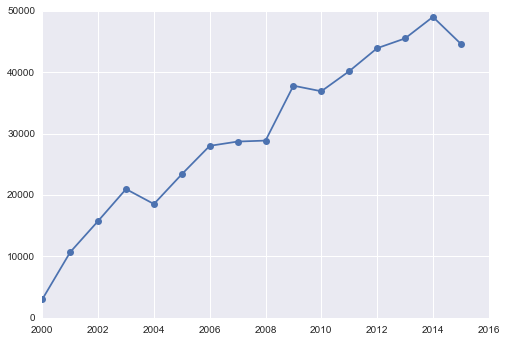

In [9]:
particip = []
years = range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1)
for year in years:
    particip.append(cantons_per_year[year].sum())
plt.plot(years,particip,marker='o')

In [10]:
cantons = geodata.LivingCanton.unique()
cantons = cantons[cantons!='nan']
cantons

array(['VS', 'BE', 'FR', 'JU', 'AG', 'VD', 'SO', 'LU', 'ZG', 'NE', 'ZH',
       'BL', 'TG', 'BS', 'TI', 'GE', 'GR', 'SH', 'AR', 'SG', 'AI', 'UR',
       'SZ', 'GL', 'NW', 'OW', 'BE/NE'], dtype=object)

In [11]:
time_evolution = pd.DataFrame()
for year in years:
    if 'BE/NE' in cantons_per_year[year].index:
        cantons_per_year[year]['BE']+=cantons_per_year[year]['BE/NE']
    time_evolution[year]=cantons_per_year[year]
cantons = cantons[cantons!='BE/NE']
time_evolution = time_evolution.set_index(cantons)
time_evolution

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
VS,1088,2799,2625,3257,3640,3629,4130,4426,4812,5003,4772,5497,5720,5304,5795,5665
BE,564,931,1404,1685,1903,2206,2408,2248,2191,2498,2472,2496,2611,2690,2981,2794
FR,168,659,737,973,563,639,778,1542,1450,1725,1994,2371,2653,2976,3142,3290
JU,146,1151,1532,3336,3691,3708,4589,4674,4896,5431,4091,4619,4963,4717,5141,3145
AG,139,687,789,1061,1149,1396,1371,1453,1200,1391,1302,1414,2199,2172,2303,1854
VD,139,383,508,803,1036,1619,1602,1383,1452,1504,1164,1218,1172,1146,1179,915
SO,137,927,1664,2189,1090,1762,3334,3358,2591,6118,6750,7132,7155,8527,9952,9687
LU,122,545,826,1092,1080,944,1384,1385,1488,2163,2211,2046,2104,2262,2216,1665
ZG,79,305,295,415,452,483,497,520,581,651,714,766,879,830,883,584
NE,75,137,192,192,184,175,227,241,298,380,333,328,284,206,260,213


In [43]:
time_evolution.to_csv('time_evol_per_canton.csv',encoding='latin1')

# Plots

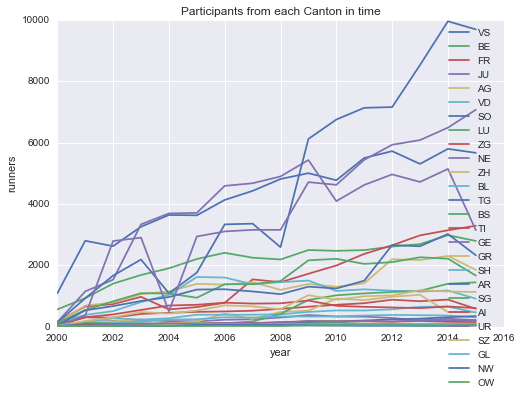

In [12]:
time_evolution = pd.read_csv('time_evol_per_canton.csv',encoding='latin1')
time_evolution = time_evolution.rename(columns={'Unnamed: 0' : 'canton'})
time_evolution = time_evolution.set_index('canton')
for i in time_evolution.index:
    plt.plot(time_evolution.loc[i],marker='None',label=str(i))
plt.legend()
plt.title('Participants from each Canton in time')
plt.xlabel('year')
plt.ylabel('runners')

In [45]:
# population density per canton
canton_population = pd.read_excel('canton_population.xlsx')
canton_population = canton_population[['Canton','Population','Area']]
canton_population = canton_population.set_index('Canton')

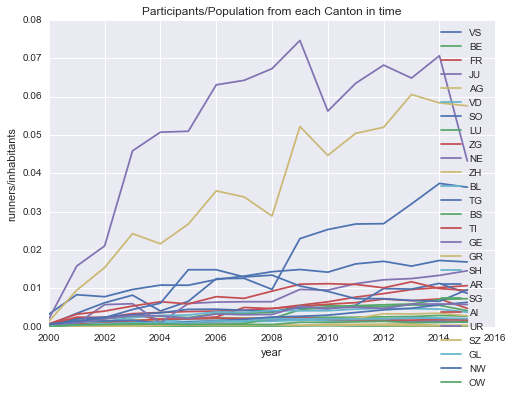

In [46]:
for i in time_evolution.index:
    plt.plot(time_evolution.loc[i]/canton_population.loc[i].Population,marker='None',label=str(i))
plt.legend()
plt.title('Participants/Population from each Canton in time')
plt.xlabel('year')
plt.ylabel('runners/inhabitants')

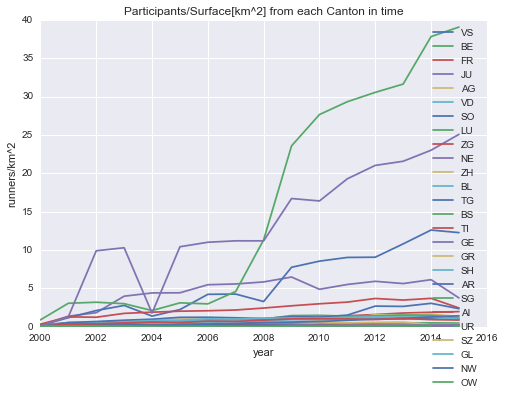

In [47]:
for i in time_evolution.index:
    plt.plot(time_evolution.loc[i]/canton_population.loc[i].Area,marker='None',label=str(i))
plt.legend()
plt.title('Participants/Surface[km^2] from each Canton in time')
plt.xlabel('year')
plt.ylabel('runners/km^2')

In [48]:
from bokeh.plotting import figure, output_file, show
# output to static HTML file
output_file("line.html")

p = figure(title = 'Number of participants vs time', plot_width=400, plot_height=400)
p.title.align = "center"
p.title.text_font_size = "16px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '14px'
p.yaxis[0].axis_label_text_font_size = '14px'

# add a circle renderer with a size, color, and alpha
p.line(years, particip, color="navy", line_width=1.5)
p.circle(years, particip, size=10, color="navy", alpha=0.5)

# show the results
show(p)

In [62]:
colors = ['blue','red','green','orange','navy','chartreuse','darkmagenta','darkgoldenrod','darkslategrey','royalblue']

# output to static HTML file
output_file("plot.html")

years = range(2000,2016)
p = figure(title = 'Runners from some Cantons vs time', plot_width=600, plot_height=600)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['SO','BE','VD','VS','ZH','GE','TI','FR']
for k in range(len(subindex)):
    i = subindex[k]
    p.line(years, time_evolution.loc[i], legend = i, color=colors[k], line_width=2)
    p.circle(years, time_evolution.loc[i], size=7, color=colors[k])
p.legend.location = "top_left"
p.legend.label_text_font_size = '16px'
show(p)

In [65]:
from bokeh.models import Label
output_file("plot.html")
p2 = figure(title = 'Ratio runners / Canton population vs time', plot_width=600, plot_height=600)
p2.title.align = "center"
p2.title.text_font_size = "18px"
p2.xaxis[0].axis_label = 'year'
p2.yaxis[0].axis_label = 'runners/population'
p2.xaxis[0].axis_label_text_font_size = '16px'
p2.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['JU','SO','VD','VS','FR','BE','GE','ZH']
for k in range(len(subindex)):
    i = subindex[k]
    p2.line(years, time_evolution.loc[i]/canton_population.loc[i].Population, legend = i, color=colors[k], line_width=2)
    p2.circle(years, time_evolution.loc[i]/canton_population.loc[i].Population, size=7, color=colors[k])
p2.legend.location = "top_left"
p2.legend.label_text_font_size = '16px'
# show the results
show(p2)

Influence of geography on performance: ANOVA analysis. Define groups:
- Jura: Jura, Neuchatel, Schaffhausen, Solothurn, Basel (Stadt, Land)
- Plateau: Zurich, Vaud, Fribourg, Aargau, Thurgau, Geneva, Appenzel
- Alps: remaining

In [13]:
jura = ['JU','SH','NE','SO','BS','BL']
plateau = ['ZH','VD','FR','GE','AG','TH','AI','AR']
alps = list((set(cantons).difference(set(jura).union(set(plateau)))).union({'BE/NE'}))

In [14]:
geo = {}
for k in jura:
    geo[k]='Jura'
for k in plateau:
    geo[k]='plateau'
for k in alps:
    geo[k]='Alps'

In [32]:
geoarea = []
for k in geodata.index:
    geoarea.append(geo[geodata.loc[k].LivingCanton])
geodata['geoarea']=geoarea

Results with this splitting:

In [33]:
geodata.geoarea.value_counts()

plateau    252551
Alps       158520
Jura        64915
Name: geoarea, dtype: int64

Focus on female marathon:

In [34]:
df = geodata[(geodata.Sex=='F') &  (geodata.Distance>=30.0) & (geodata.Distance<=60.0)]

In [35]:
print('Overall mean: '+str(np.mean(df.Time)))
print('Jura mean: '+str(np.mean(df[df.geoarea=='Jura'].Time)))
print('Plateau mean: '+str(np.mean(df[df.geoarea=='plateau'].Time)))
print('Alps mean: '+str(np.mean(df[df.geoarea=='Alps'].Time)))

Overall mean: 0 days 04:27:02.464601
Jura mean: 0 days 04:34:26.996542
Plateau mean: 0 days 04:23:20.568621
Alps mean: 0 days 04:28:06.699503


Cantonal differences:

In [47]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.plotting import figure, output_file, show

df = geodata[(geodata.Sex=='F') &  (geodata.Distance>=30.0) & (geodata.Distance<=60.0)]

colors = {}
colors['Jura']='orange'
colors['plateau']='green'
colors['Alps']='royalblue'
df.Time = df.Time.apply(lambda x: x.total_seconds()/60)
geodata['color']=geodata.geoarea.apply(lambda y: colors[y])
agg = df[['Time','LivingCanton','geoarea','color']]
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='color',marker='square',title='mean time boxplot for female marathon (30-60 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

output_file("boxplot.html")

show(p)

C:\Users\Utente\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


ANOVA on test case (female marathon); in one case verify NORMALITY and HOMOSCHEDASTICITY

In [51]:
import scipy.stats as stats
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [79]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.f_oneway(samples[i],samples[j])[1]

In [95]:
P_VALUES = pd.DataFrame()
for j in range(len(cantons)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(cantons)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=cantons)
    P_VALUES[cantons[j]]=col

In [103]:
P_VALUES.loc['TI']

VS    1.571369e-35
BE    1.148305e-79
FR    2.538429e-31
JU    2.417235e-08
AG    6.083820e-58
VD    1.253204e-39
SO    6.042504e-39
LU    8.601627e-41
ZG    1.141646e-36
NE    2.682169e-22
ZH    1.630739e-65
BL    1.692601e-45
TG    2.337923e-30
BS    4.471792e-43
TI    1.000000e+00
GE    3.071914e-22
GR    7.407669e-34
SH    1.707209e-21
AR    2.807191e-07
SG    2.601286e-45
AI    1.596361e-16
UR    3.551039e-08
SZ    2.370251e-13
GL    1.363021e-11
NW    2.282852e-14
OW    1.736230e-19
Name: TI, dtype: float64

Check hypotheses in one random case

In [138]:
output_file("heteroschedasticity.html")

Nc = 1
sample = samples[Nc]
p = figure(title = 'Heteroschedasticity hypothesis for Canton '+str(cantons[Nc]), plot_width=400, plot_height=400)
p.title.align = "center"
p.title.text_font_size = "16px"
p.xaxis[0].axis_label = 'index'
p.yaxis[0].axis_label = 'residuals'
p.xaxis[0].axis_label_text_font_size = '14px'
p.yaxis[0].axis_label_text_font_size = '14px'

# add a circle renderer with a size, color, and alpha
p.line(x=[0,len(sample)],y=[0,0],line_width=2,line_dash=[3,3],color='red')
p.circle(range(0,len(sample)), sample-np.mean(sample), size=5, color="navy", alpha=0.5)

# show the results
show(p)

In [155]:
# normality hypothesis: Gaussian distribution, Shapiro-Wilk test
import math

Nc = 14
sample = samples[Nc]
shapirowilk = stats.shapiro(sample)[1]

# add a circle renderer with a size, color, and alpha
from bokeh.charts import Histogram, output_file, show

df = pd.DataFrame({'time':sample})
p = Histogram(df,values='time',color='navy',bins=30,
              title='Time PDF for Canton ' +str(cantons[Nc]),
              density=True,legend='top_right')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'time [minutes]'
p.yaxis[0].axis_label = 'density'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
m = np.mean(sample)
sigma = np.std(sample)
def gaussian(y,m,sigma):
    return 1/math.sqrt(2*math.pi*sigma*sigma)*math.exp(-(y-m)*(y-m)/2/(sigma*sigma))
yy = np.arange(np.min(sample), np.max(sample), 0.1)
gg = []
for k in range(len(yy)):
    gg.append(gaussian(yy[k],m,sigma))
p.line(list(yy),gg,line_width=2,color='red',legend='Gaussian')

output_file("histogram_bins.html")

show(p)